# SPRINT 8 - Visualización de datos con Python

In [25]:
# Paso 1: conectar con la base de datos existente
import configparser
import mysql.connector
import pandas as pd
import sys

LF="\n"
def is_defined(varname):
    return varname in globals()
def is_dataFrame(varname):
    return is_defined(varname) \
        and type(globals().get(varname)) is pd.core.frame.DataFrame

def db_connect():
    try:
        cfgFp = open('db.ini', mode='r')
        iniFp = configparser.ConfigParser()
        iniFp.read_file(cfgFp)
        dbCfg = dict(iniFp.items('database'))

        # print(dbCfg, dbCfg['host'])

        if not is_defined('db'):
            global db
            db = mysql.connector.connect(
                host=dbCfg['host'],
                database=dbCfg['database'],
                user=dbCfg['user'],
                password=dbCfg['password']
            )
            print("Conectado!")

    except Exception as e:
        exit("Error:", e)

# Aquí configurando cosas de genéricas de Pandas
pd.set_option("display.max.columns", None)
pd.options.mode.copy_on_write = True

# db_connect()

## Tarea S08.01

### Nivel 1
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.

<div class="alert alert-block alert-warning">

**NOTA:**  
Esta descripción es un tanto confusa: Python **NO** se conecta con *MySQL Workbench*; se puede conectar con el **servidor** de base de datos (RDBMS: _Relational DataBase Management Server_) MySQL (o MariaDB, o PostgreSQL, o...). *MySQL Workbench* es un **cliente** (que sí, puede gestionar el servidor) que se conecta al RDBMS, igual que lo hará Python.  
Puede que parezca "más fácil de entender", pero sigue siendo incorrecto.

Si en una entrevista técnica el aspirante dijese eso, posiblemente perdería puntos.
</div>

Realitzaràs una visualització per a cada exercici. Comenta el que et crida l'atenció de graficar aquesta variable, justifica l'elecció del gràfic i interpreta els resultats en funció de les teves dades.

####

#### Conectar a DB y tablas
Conectando a la DB y cargando las tablas que se usarán en los ejercicios.

In [21]:
if not is_defined('db'):
    db_connect()

# extraer los datos de la DB. Iré añadiendo tablas según las vaya usando...
def load_tables():
    global tr_df, user_df, co_df, pr_df, prtr_df
    try:
        if not is_dataFrame('tr_df'):
            tr_df   = pd.read_sql("SELECT * FROM `transaction`", db)
            print("Tabla 'transaction' cargada correctamente")

        if not is_dataFrame('user_df'):
            user_df = pd.read_sql("SELECT * FROM `user`", db)
            print("Tabla 'user' cargada correctamente")

        if not is_dataFrame('co_df'):
            co_df = pd.read_sql("SELECT * FROM company", db)
            print("Tabla 'company' cargada correctamente")

        if not is_dataFrame('prtr_df'):
            pr_df   = pd.read_sql("SELECT * FROM product", db)
            prtr_df = pd.read_sql("SELECT * FROM product_transaction", db)
            print("Tabla 'company' cargada correctamente")

    except:
        print("Error leyendo la DB...")

#### T8.01 N1E1 Visualización de una variable numérica

He elegido representar las operaciones declinadas y completadas.

Para ello, hay que agrupar y contar las operaciones teniendo en cuenta si fueron completadas o no:
º

tr_df existe? True
<class 'pandas.core.frame.DataFrame'>
user_df existe? True
<class 'pandas.core.frame.DataFrame'>
co_df existe? True
<class 'pandas.core.frame.DataFrame'>
prtr_df existe? True
<class 'pandas.core.frame.DataFrame'>


C:\Users\formacio\AppData\Local\Temp\ipykernel_6340\3561970872.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db, columns=["declined"])


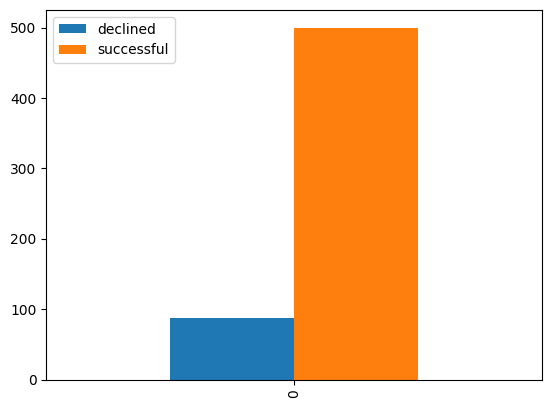

In [22]:

load_tables()

query = '''
SELECT SUM(declined)   AS declined
     , SUM(declined=0) AS successful
  FROM `transaction`
'''
if db and db.is_connected:
    df = pd.read_sql(query, con=db, columns=["declined"])
    df.plot.bar()

Aunque... supongo que si se trata de usar pandas, la idea es hacer la selección y agregación usando la biblioteca y no SQL, ya que la "_gracia_" está en importar datos de Excel/hojas de cálculo, tablas HTML, CSV... donde no hay cómo hacer un GROUP BY o un MAX().
(Esto no se dice tampoco en el enunciado... Solo "conectar a la DB"; si conecto a una DB para hacer un select, a algunos la manipulación se nos va directamente a SQL).

<Axes: title={'center': 'Transactions'}, xlabel='Status', ylabel='# of transactions'>

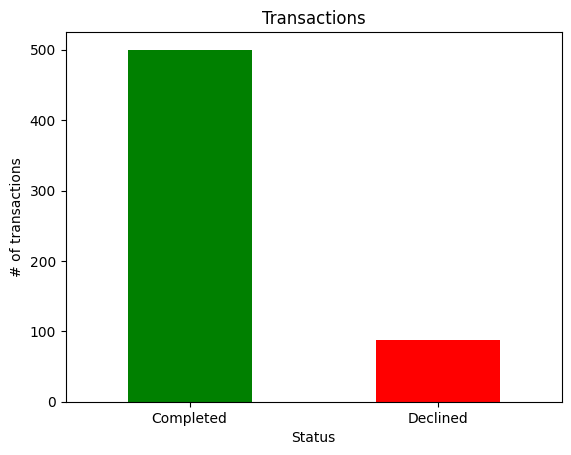

In [23]:
# Usando pandas para "calcular" las columnas, y crear el gráfico renombrando las columnas de "0" y "1" a "Completadas" y "Declinadas"ArithmeticErrordecl_df = tr_df.groupby('declined').count()
decl_df = tr_df.groupby('declined').count()

decl_df = decl_df.rename({0: "Completed", 1: "Declined"}, axis='index')['transaction_id']
# decl_df = decl_df['transaction_id']
# print(decl_df)
decl_df.plot.bar(
    title="Transactions",
    xlabel="Status",
    ylabel="# of transactions",
    color=['green', 'red'],
    rot=0
)

Pero esa variable (`declined`) resulta que es _booleana_, por más de sea un `0` o un `1` y la esté sumando...

Así que para crear un gráfico con una variable numérica, he añadido una nueva columna al dataset ("age"), para poder ver la distribución de edades de los compradores, trabajando así con una variable numérica:

<Axes: title={'center': 'Age distribution'}, xlabel='Age', ylabel='# of Users'>

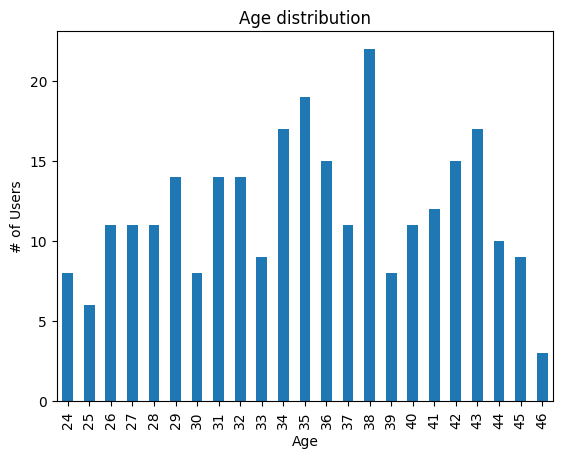

In [110]:
import dateutil
from pandas import to_datetime

def age(birthdate):
    dob = to_datetime(birthdate).date() if type(birthdate) is not str \
                  else dateutil.parser.parse(birthdate).date()
    hoy = dateutil.utils.today().date()
    ddiff = hoy - dob
    edad  = int(ddiff.days / 365.25)
    # print(edad, "años")
    return edad

# Add age column to user dataframe
user_df["age"] = user_df['birthdate'].map(age)

user_df.groupby('age')['age'] \
        .count() \
        .plot.bar(
            x='age',
            title="Age distribution",
            ylabel="# of Users",
            xlabel="Age"
        )

Observando la gráfica, vemos que no hay una distribución uniforme y, por tanto, podría decirse que las edades son "aleatorias" en su distribución, quizá con una prevalencia en la franja de 26 a 29 años, pero no es significativa.

<Axes: ylabel='Frequency'>

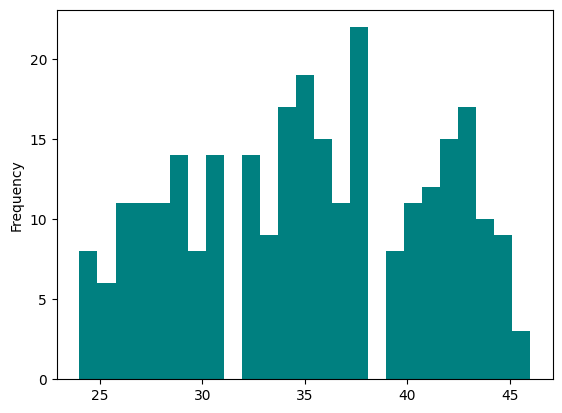

In [111]:
user_df['age'].plot.hist(bins=25, color='teal')

#### T8.01 N1E2 dues variables numèriques
Podría ser el valor de la transacción por... número de transacciones? ¿Tiene algún sentido?
Qui´za reuperando algún ejercicio anterior; por ejemplo: los productos más vendidos y el precio...
```sql
SELECT product_name, price
     , COUNT(transaction_id)   AS transaction_count
     , COUNT(DISTINCT user_id) AS buyers_count
  FROM user_products
 GROUP BY product_name, price
 ORDER BY 3 DESC, 4 DESC,2 DESC
 ```

In [74]:
load_tables()

def fullname(row):
    return f"{row['name']} {row['surname']}"

user_df.drop('client', axis=1) if 'client' in user_df else print()

if 'Client' not in user_df:
    user_df['Client'] = user_df.apply(fullname, axis=1)

# user_df['Client'].head()
productos = prtr_df.merge(pr_df) \
                   .merge(tr_df) \
                   .merge(user_df)

productos.head()

productos.groupby(['Client'])['product_id'].count()

Client
Acton Gallegos      3
Aiko Chaney         7
Ainsley Herrera     1
Alan Vazquez        2
Alika Kinney        3
                   ..
Zane Collier        6
Zelenia Good        1
Zeph Schmidt        4
Zephania Collins    5
Zoe Morrow          4
Name: product_id, Length: 216, dtype: int64

#### T8.01 N1E3 Una variable categòrica
Podríamos listar los países de las compañías...

<Axes: title={'center': "Companies' Countries"}, xlabel='Country', ylabel='Companies'>

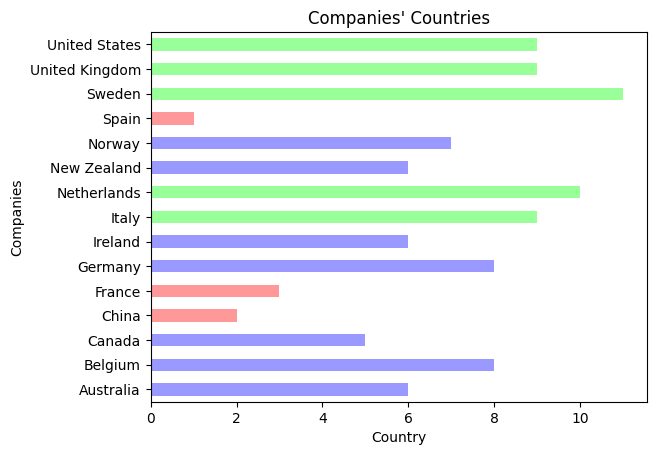

In [173]:
db_connect()

load_tables()

def get_color(number, color_map):
    sorted_keys = sorted(key for key in color_map.keys() if isinstance(key, int))

    # Primero los valores extremos...
    if number < sorted_keys[0]:
        return color_map[sorted_keys[0]]
    elif number > sorted_keys[-1]:
        return color_map['else']
    
    # Ahora los valores de las keys
    for key in sorted_keys:
        if number < key:
            return color_map[key]
    
    return color_map[sorted_keys[-1]]

def column_colors(values, color_map: dict):
    '''
    Calculates a color list for a given list of values, setting the color
    for that value from a dictionary.
    
    The 'else' key sets the color for any value greater than the last defined.
    The dict will be sorted numerically, so is it not necessary (but better for
    legibility) to create it already sorted.

    Usage:
        values = [2,4,5,7,9]
        colormap1 = {4: 'red', 8: 'amber', 'else': 'green'}
        colormap2 = {3: 'orange', 5: 'amber', 8: 'cyan', 'else': 'green'}
        
        column_color(values, colormap1)

        Would return

        ['red', 'amber', 'amber', 'amber', 'green']

        While

        column_color(values, colormap2)

        Should return

        ['orange', 'amber', 'amber', 'cyan', 'green']
    '''
    cc = []
    
    for n in values:
        cc.append(get_color(n, color_map))
    return cc

pastel_3colors = {4: '#f99', 8: '#99f', 'else': '#9f9'}
graph_data     = co_df.groupby('country')['country'].count()#.sort_values()

cc = column_colors(graph_data, pastel_3colors)
# print(cc)
graph_data.plot.barh(
            x='age',
            title="Companies' Countries",
            ylabel="Companies",
            xlabel="Country",
            color=cc
        )

#### T8.01 N1E4 Una variable categòrica i una numèrica
¿Total y cantidad de compras por mes? En una gráfica doble... Hmmm... ¿El mes es una variable categórica o numérica? En realidad se usa el valor numérico para agrupar, pero también es cierto que serviría igual el nombre del mes.

(También, podríamos considerar que la gráfica anterior tiene una variable categórica: los países, y una numérica: la cantidad de vendedores).

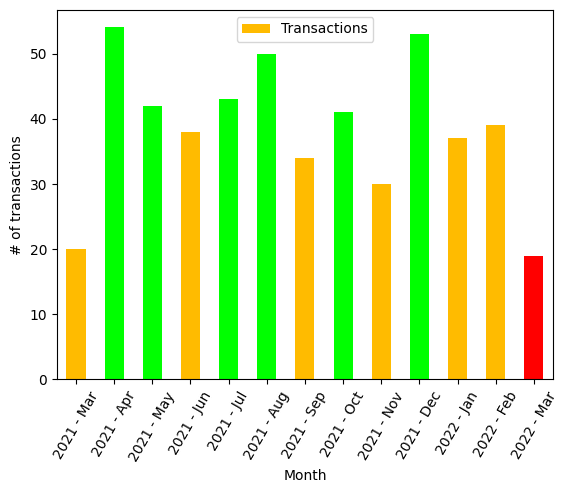

In [217]:
from matplotlib import pyplot, ticker
from datetime import datetime

db_connect()
load_tables()

tr_df_agg  = tr_df[tr_df['declined']==0]  \
                        .get(['amount', 'transaction_ts'])  \
                        .groupby(pd.Grouper(
                            key='transaction_ts',
                            axis=0,
                            origin='start',
                            sort=True,
                            freq='ME'
                        )) \
                        .agg(['sum', 'count'])
tr_agg     = tr_df_agg['amount']
bar_values = tr_agg['count'].to_list()

semaphor_colors = {
    20:     '#f00',
    40:     '#fb0',
    'else': '#0f0'
}
cc = column_colors(bar_values, semaphor_colors)

xticks = [d.date().strftime('%Y - %b') for d in tr_agg.index]

graph = tr_agg['count'].plot.bar(
    # kind="bar",
    color=cc,
    rot=60,
    ylabel="# of transactions",
    xlabel="Month",
    label="Transactions"
)
graph.legend(["Transactions"])
graph.set_xticks(range(0, xticks.__len__()), xticks)

#### T8.01 N1E6 tres variables
Aquí tenemos un agrupamiento por **país**, y mostrando la **cantidad de transacciones** _y_ el **valor** de dichas operaciones.

In [83]:
db_connect()

if db and db.is_connected:
    if 'co_df' not in globals() or type(co_df) is not pd.core.frame.DataFrame:
        load_tables()
# tr_df.head()
# co_df.head()
cotr_df = co_df.merge(tr_df, how='inner', on='company_id')

cotr_df.head()

,company_id,company_name,phone,email,country,website,transaction_id,user_id,credit_card_id,product_ids,transaction_ts,amount,latitude,longitude,declined
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site,108B1D1D-5B23-A76C-55EF-C568E49A05DD,275,CcU-2938,[59],2021-07-07 17:43:16,293.57,83.7839,-178.8600,0
1,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site,EA2C3281-C9C1-A387-44F8-729FB4B51C76,275,CcU-2938,"[59, 79, 37, 73]",2021-05-09 10:25:08,119.36,20.2004,-116.8400,1
2,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9,7DC26247-20EC-53FE-E555-B6C2E55CA5D5,275,CcU-2945,"[71, 41]",2022-02-04 15:52:56,312.50,58.9367,-76.8171,0
3,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9,FE96CE47-BD59-381C-4E18-E3CA3D44E8FF,275,CcU-2945,[3],2021-06-15 00:26:29,480.13,-21.8805,-112.5880,1
4,b-2230,Fusce Corp.,08 14 97 58 85,risus@protonmail.edu,United States,https://pinterest.com/sub/cars,72997E96-DC2C-A4D7-7C24-66C302F8AE5A,275,CcU-2952,"[97, 41, 3]",2022-01-30 15:16:36,239.87,43.3584,-17.6580,0


   declined  successful
0      87.0       500.0
['#f00', '#f00', '#fb0', '#f00', '#f00', '#0f0', '#fb0', '#f00', '#f00', '#f00', '#0f0', '#f00', '#0f0', '#0f0', '#f00']
             amount      
                sum count
country                  
Australia   1063.99     6
Belgium     2041.74     8
Canada     14930.69    57
China        444.48     2
France       508.23     3


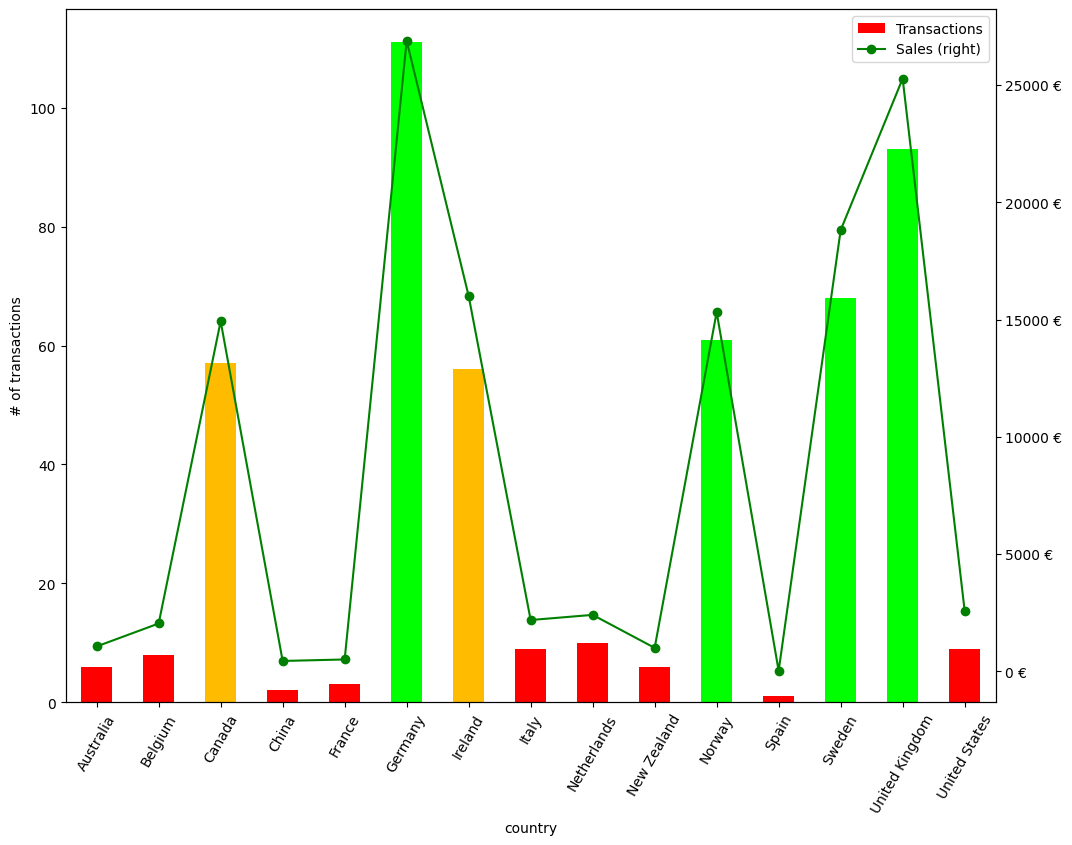

In [ ]:
from matplotlib import ticker

db_connect()
load_tables()

cotr_df = co_df.merge(tr_df, how='inner', on='company_id')

tr_agg  = cotr_df[cotr_df['declined']==0]  \
                        .get(['amount', 'country'])  \
                        .groupby('country')  \
                        .agg(['sum', 'count'])

fig, ax = pyplot.subplots()
xLabels = tr_agg['amount'].index

semaphor_colors = {
    20:     '#f00',
    60:     '#fb0',
    'else': '#0f0'
}

cc = column_colors(tr_agg['amount']['count'], semaphor_colors)
# print(cc)
# print(tr_agg.head())

graph = tr_agg['amount']['count'].plot(
    kind="bar",
    figsize=(12,9),
    color=cc,
    rot=60,
    ylabel="# of transactions",
    label="Transactions",
    legend=True,
    ax=ax
)
graph.legend(labels=("Transactions", "Sales"))

# Ventas en otra escala, para que sea visible...
graph2 = tr_agg['amount']['sum'].plot(
    kind='line',
    secondary_y=True,
    legend=True,
    ax=graph,
    color='green',
    marker='o',
    rot=60,
    label="Sales"
)
graph2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d €'))